Important Links
#Weights https://github.com/matterport/Mask_RCNN/releases
#https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/
#Noise Removal https://stackoverflow.com/questions/52471456/how-to-remove-edge-noises-from-an-object-in-an-image


In [1]:
#Importing Libraries
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline


/home/coss22/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/coss22/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/coss22/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/coss22/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [2]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [6]:
#We have converted our videos into frames 
atm_frames_dir="images/atm_video_frames"
atm_frames_names=os.listdir(atm_frames_dir)


frame_number=[]

for frame in atm_frames_names:
    frame_number.append([int(s) for s in frame.split('.') if s.isdigit()])
frame_number=sorted(frame_number)
frame_number=np.ravel(frame_number)

Processing 1 images
image                    shape: (576, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


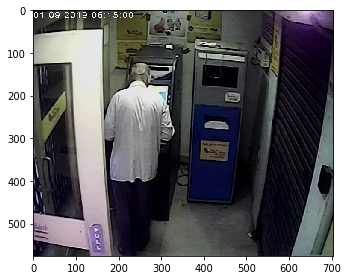

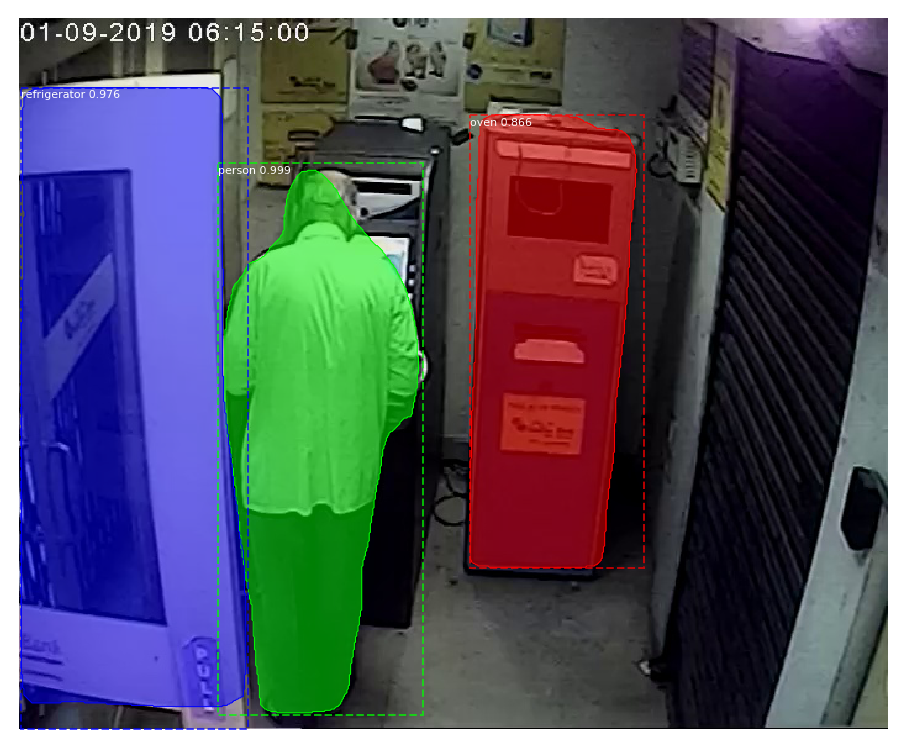

Processing 1 images
image                    shape: (576, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


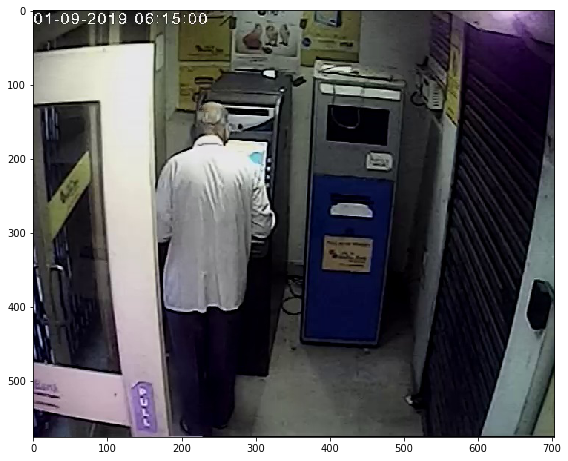

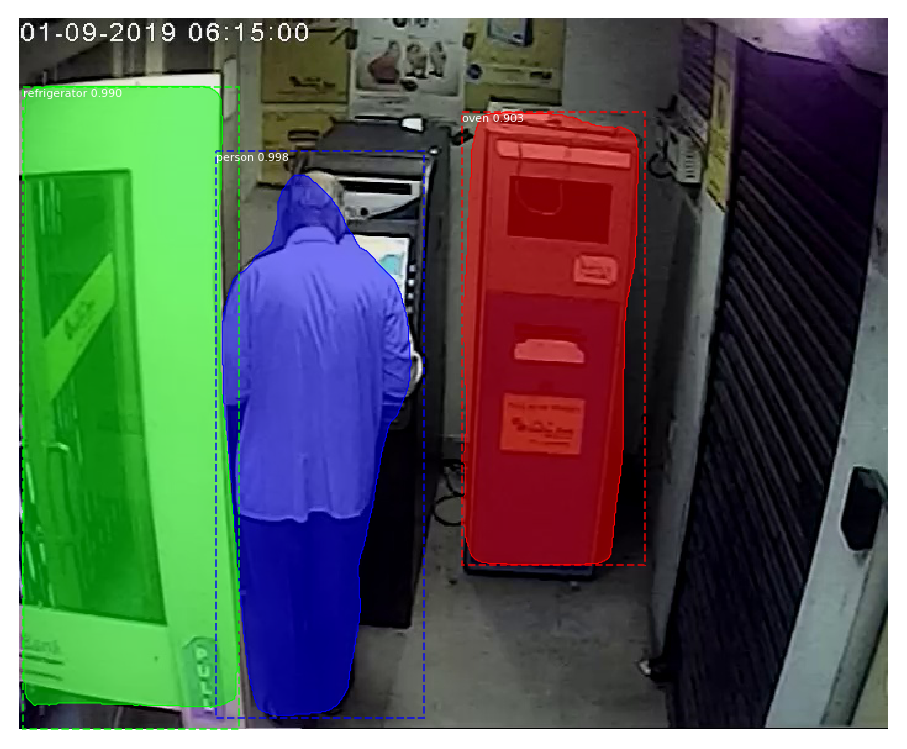

Processing 1 images
image                    shape: (576, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


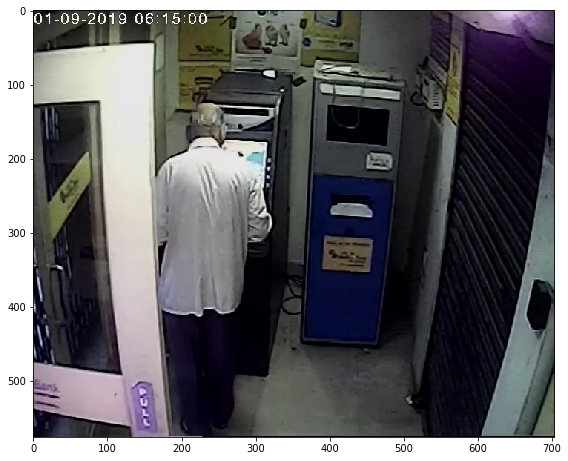

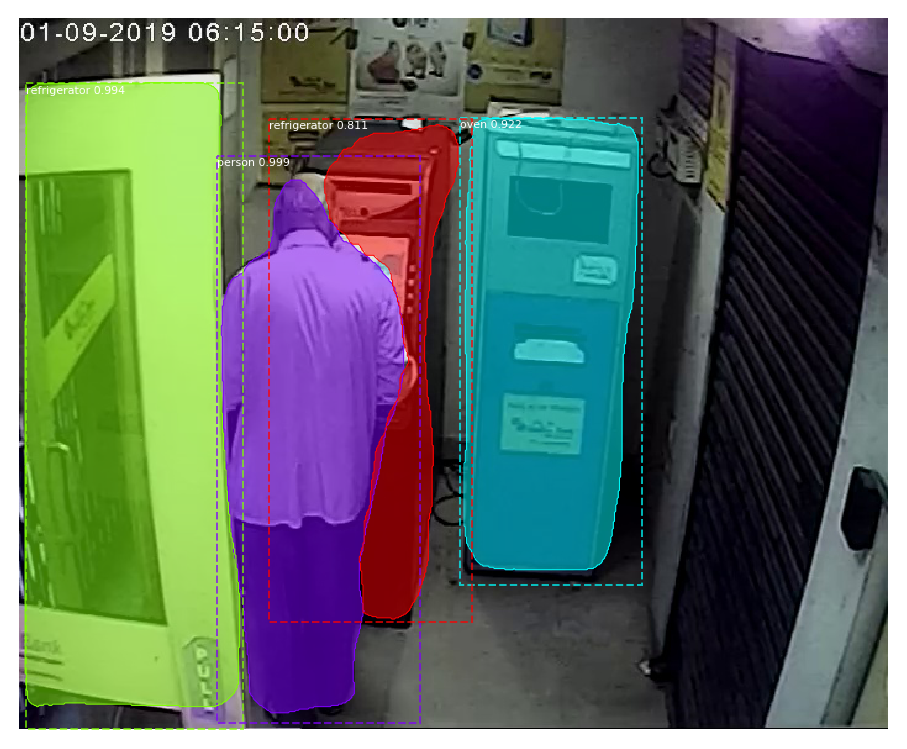

Processing 1 images
image                    shape: (576, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


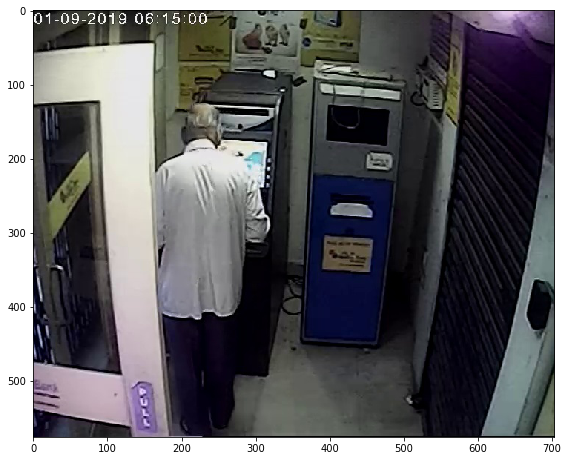

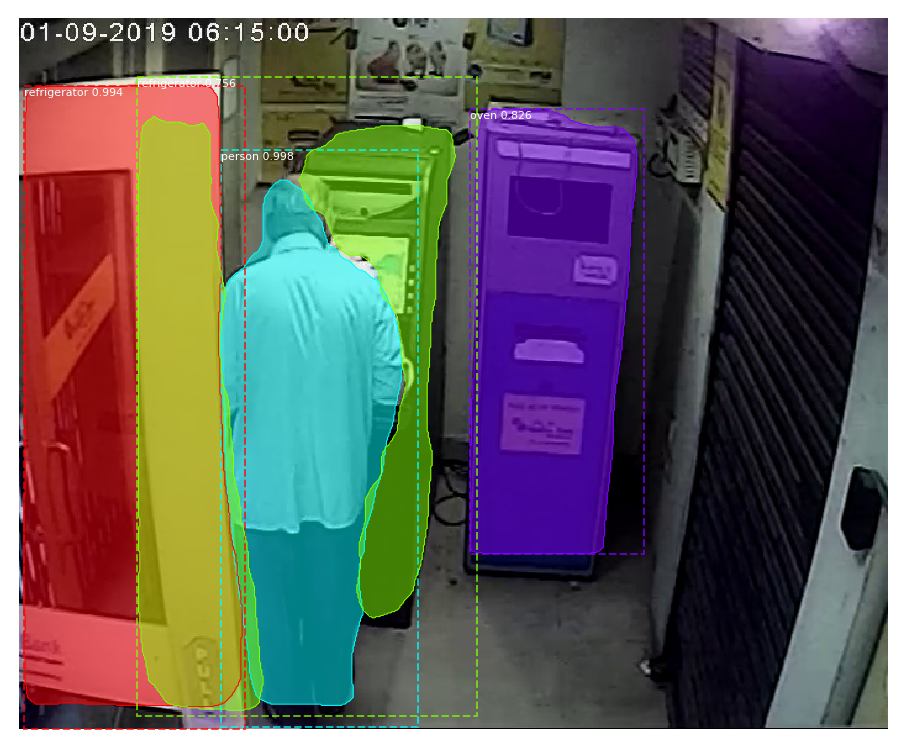

Processing 1 images
image                    shape: (576, 704, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [ ]:
for frame_name in range(1,200):
    frame_path=atm_frames_dir+"/"+str(frame_name)+".jpg"
    #print(frame_path)
    frame=skimage.io.imread(frame_path)
    # original image
    plt.imshow(frame)
    skimage.io.imshow(frame)
    
    # Run detection
    results = model.detect([frame], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    
    classes_found=len(r['class_ids'])
    for each_object in range(len(['class_ids'])):
        if r['class_ids'][each_object]==1:
            mask = r['masks']
            mask = mask.astype(int)
            mask.shape
            temp=frame
            
            for j in range(temp.shape[2]):
                temp[:,:,j] = temp[:,:,j] * mask[:,:,each_object]
            plt.figure(figsize=(8,8))
            plt.imshow(temp)
            
            original_frame=cv2.imread(frame_path)
            cv2.imwrite("images/original_frames_extract/"+str(frame_name)+".jpg",original_frame)
            
            segment_frame=str(frame_name)+"_"+str(each_object)+".jpg"
            cv2.imwrite("images/segmented_frames/"+segment_frame,temp)
            gray = cv2.imread("images/segmented_frames/"+segment_frame, cv2.IMREAD_GRAYSCALE)

            #  eliminate white blobs
            kernel = np.ones((5, 5), np.float32)/25
            processedImage = cv2.filter2D(gray, -1, kernel)
            gray[processedImage<0] = 0

            #  eliminate pixels with very large value
            gray[gray<0] = 0
            gray[gray>0]=255
            #  eliminate last remeaning outlier white pixels
            gray = cv2.medianBlur(gray, 5)

            #displayresult
            plt.imshow(gray)
            cv2.imwrite("images/activity_frames/"+segment_frame+".jpg",gray)

In [10]:
#Video Creation
import os
import glob
import numpy as np
from datetime import datetime

from moviepy.editor import VideoFileClip,concatenate_videoclips


#Merging Remaining Clips


all_frames=os.listdir("images/original_frames_extract/")
frame_number=[]

for frame in all_frames:
    frame_number.append([int(s) for s in frame.split('.') if s.isdigit()])
frame_number=sorted(frame_number)
frame_number=np.ravel(frame_number)

#Merging all clips into one 
clips = []

for x in frame_number:
    frame="images/original_frames_extract/{}.jpg".format(x)
    clips.append(VideoFileClip(frame))
     
final_clip = concatenate_videoclips([x for x in clips])

dateTimeObj=datetime.now()
videoname ="HighligtVideo"+dateTimeObj.strftime("%d %b %Y %H %M %S")
#finally merging all clips into one

#For creating directory Highlight_CV , if it is not exist
if not os.path.exists("highlight"):
        os.makedirs("highlight");

#Writing the video files into Highlight_CV Folder
final_clip.write_videofile("highlight/{}.mp4".format(videoname))

t:   9%|▊         | 6/70 [00:00<00:01, 59.45it/s, now=None]

Moviepy - Building video highlight/HighligtVideo26 Feb 2020 23 52 58.mp4.
Moviepy - Writing video highlight/HighligtVideo26 Feb 2020 23 52 58.mp4



Moviepy - Done !
Moviepy - video ready highlight/HighligtVideo26 Feb 2020 23 52 58.mp4
